In [1]:
library(tidyverse)
options(jupyter.plot_mimetypes = c("image/svg+xml"))
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Read data sets in

In [2]:
datasets <- c("copynumber", "expression", "methylation", "screening")
library(digest)
remove_duplicates <- function(df) {
    md5 <- map(df, digest)
    df[, !duplicated(md5)]
}
datasets <- str_c("/scratch/bdsi/", datasets, ".rds") %>% 
            map(readRDS) %>% 
            map(~ as_tibble(., rownames="CELL_LINE_NAME")) %>%
            map(~ setNames(., make.names(names(.)))) %>% # eliminate invalid R col. names
            setNames(datasets) # %>% map(remove_duplicates)
attach(datasets)

Confusingly, the three genomic data sets have different IDs in the rownames:

In [3]:
intersect(copynumber$CELL_LINE_NAME, expression$CELL_LINE_NAME) %>% length
intersect(copynumber$CELL_LINE_NAME, methylation$CELL_LINE_NAME) %>% length

[1] 850

[1] 0

We can fix this with a quick join. We will use `data.table` for merges as it's much faster.

In [4]:
library(data.table)
cl_map <- screening %>% distinct(CELL_LINE_NAME, CL) %>% mutate(CL = as.character(CL)) %>% 
          as.data.table
ec = list(copynumber, expression) %>% map(rename, CL = CELL_LINE_NAME) %>% 
     map(as.data.table) %>% map(setkey, "CL") %>% map(~ .[cl_map, on="CL"]) %>% 
     map(setkey, "CELL_LINE_NAME") %>% map(~ .[,CL:=NULL])
methylation <- as.data.table(methylation) %>% setkey("CELL_LINE_NAME")
combined_features <- c(ec, list(methylation)) %>%
                     reduce(~ .x[.y, on = "CELL_LINE_NAME", nomatch = 0]) %>% 
                     setcolorder("CELL_LINE_NAME")


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [5]:
dim(combined_features)

[1]    850 549471

## Imputation & dimensionality reduction
The feature data sets seem to be too large for most off-the-shelf imputation methods. We'll resort to matrix completion. (Actually, we will get a low-rank SVD for free which can immediately be thrown into a classifier.)

In [6]:
M <- as.matrix(combined_features[, 2:ncol(combined_features)])
dim(M)

[1]    850 549470

In [32]:
library(softImpute)
# si <- softImpute(M, trace=T, rank.max=100, type='svd')
# this takes a while and eats a lot of memory. For convenience I have stored the result.
# save(si, file="si.RData")
load("si.RData"); 

I chose `rank.max=100` arbitrarily but the classifier will do further feature selection so it's fine to set it a little large. The numerical rank of the matrix seems much lower:

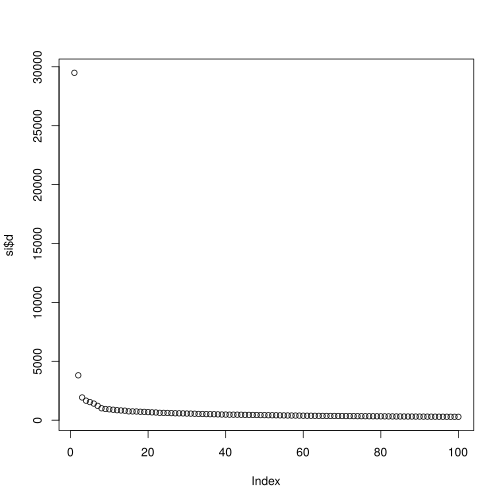

In [33]:
plot(si$d)

## Classification
Finally we join the SVD loadings to the outcome data and split into training and validation data sets. We'll use `xgboost` because it's very efficient, but many choices are possible.

To run the classifier we must one-hot encode the drug column.

In [207]:
ttv <- c("train", "test", "validate")
svd_with_ids <- data.frame(CELL_LINE_NAME=combined_features$CELL_LINE_NAME, si$u,
                           split=sample(c("train", "test", "validate"), 
                                             850, replace=T, prob=c(.8, .2, .1)))
data <- left_join(screening, svd_with_ids) %>% 
        select(EFFECT, drug, X1:X100, split)
X <- sparse.model.matrix(EFFECT ~ . - 1 - split, data=data)
splits <- ttv %>% map(~ which(data$split == .)) %>% 
                  map(~ list(X=X[.,], Y=data$EFFECT[.])) %>% 
                  setNames(ttv)

Joining, by = "CELL_LINE_NAME"
Warning message:
“Column `CELL_LINE_NAME` joining character vector and factor, coercing into character vector”

In [208]:
str(splits)

List of 3
 $ train   :List of 2
  ..$ X:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:1355016] 0 131 225 546 659 717 856 888 948 1377 ...
  .. .. ..@ p       : int [1:169] 0 101 418 758 840 842 1037 1212 1480 1727 ...
  .. .. ..@ Dim     : int [1:2] 13416 168
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:13416] "1" "2" "3" "4" ...
  .. .. .. ..$ : chr [1:168] "drug1001_2000" "drug1003_0.1" "drug1004_0.1" "drug1005_10" ...
  .. .. ..@ x       : num [1:1355016] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..@ factors : list()
  ..$ Y: logi [1:13416] TRUE TRUE TRUE TRUE FALSE TRUE ...
 $ test    :List of 2
  ..$ X:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. ..@ i       : int [1:365418] 87 225 456 524 668 828 883 1043 1154 1192 ...
  .. .. ..@ p       : int [1:169] 0 30 110 184 208 209 252 297 358 420 ...
  .. .. ..@ Dim     : int [1:2] 3618 168
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : chr [1:3618] "52" "53" "54" "55" ...
  ..

In [210]:
library(xgboost)
dtrain <- xgb.DMatrix(rbind(splits$train$X, splits$test$X),
                      label=c(splits$train$Y, splits$test$Y))  # combine train and test for cv

`xgboost` has some tuning parameters which will find by cross validation. The most important ones are the learning rate ($\eta$) and the tree depth.

In [232]:
pgrid <- expand.grid(eta=c(.01,.1,.5,1), max_depth=1:10)
# cv <- purrrlyr::by_row(pgrid, xgb.cv, data=dtrain, nrounds=1000, nfold=10, 
#                        verbose=0, early_stopping_rounds=10) %>% 
#      mutate(.out = map(.out, ~ .$evaluation_log)) %>% unnest 
# this takes a while so I saved the output again
# save(cv, file='cv.RData')
load("cv.RData")

In [233]:
head(cv)
cv %>% top_n(1, -test_rmse_mean)

  eta  max_depth iter train_rmse_mean train_rmse_std test_rmse_mean
1 0.01 1         1    0.4986740       1.019804e-05   0.4986741     
2 0.01 1         2    0.4973707       2.030788e-05   0.4973714     
3 0.01 1         3    0.4960903       3.028217e-05   0.4960908     
4 0.01 1         4    0.4948319       3.984834e-05   0.4948330     
5 0.01 1         5    0.4935956       4.964514e-05   0.4935968     
6 0.01 1         6    0.4923808       5.915539e-05   0.4923822     
  test_rmse_std
1 4.063607e-05 
2 8.080124e-05 
3 1.211906e-04 
4 1.616088e-04 
5 2.016912e-04 
6 2.415954e-04 

  eta max_depth iter train_rmse_mean train_rmse_std test_rmse_mean
1 0.1 3         994  0.1443465       0.001442513    0.2063411     
  test_rmse_std
1 0.005986675  

In [218]:
dMs <- splits %>% map(~ xgb.DMatrix(.$X, label=.$Y))
# use best parameters from grid search here
mdl <- xgb.train(params=list(objective="binary:logistic", eta=0.1, max_depth=3),
                data=dtrain, nrounds=1000, early_stopping_rounds=30,
                watchlist=dMs[c("train", "test")])

[1]	train-error:0.206172	test-error:0.186567 
Multiple eval metrics are present. Will use test_error for early stopping.
Will train until test_error hasn't improved in 30 rounds.

[2]	train-error:0.186866	test-error:0.165285 
[3]	train-error:0.206172	test-error:0.186844 
[4]	train-error:0.186866	test-error:0.165008 
[5]	train-error:0.186792	test-error:0.165837 
[6]	train-error:0.154293	test-error:0.136540 
[7]	train-error:0.186494	test-error:0.166114 
[8]	train-error:0.186196	test-error:0.165285 
[9]	train-error:0.154815	test-error:0.136263 
[10]	train-error:0.154592	test-error:0.136540 
[11]	train-error:0.171437	test-error:0.151465 
[12]	train-error:0.154442	test-error:0.136263 
[13]	train-error:0.155262	test-error:0.136263 
[14]	train-error:0.140429	test-error:0.122996 
[15]	train-error:0.140131	test-error:0.123273 
[16]	train-error:0.138417	test-error:0.122996 
[17]	train-error:0.153548	test-error:0.136540 
[18]	train-error:0.139386	test-error:0.123549 
[19]	train-error:0.140504	tes

## Validation error

In [230]:
pred = predict(mdl, dMs$validate) > 0.5
mean(pred == splits$validate$Y)

[1] 0.9276039